# Threat Detection

#### The goal of this project is to design a program that will detect possible threats such as an active shooter or in this case, a nerf gun. We will acquire model templates through picture data of a person holding a nerf gun and then we will perform template matching on video footage data. Once we acquire the best match template, using the Riemannian Manifold distance computed from the best match template and model template covariances, if the distance is less than a certain predefined threshold, an active shooter alert will be designated. Once designated, mean shift tracking will be used to continue tracking the shooter and more importantly his weapon, a nerf gun. 

#### First, we will get a nerf gun, and then we will take pictures of ourselves holding the nerf gun in different orientations and directions to create model templates. Then, we will test the method by recording video footage of ourselves holding a nerf gun and walking around as well as video footage of ourselves not holding a nerf gun. 


In [1]:
# Libraries 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
import imageio
import cv2
from skimage import morphology
from matplotlib.patches import Circle
import matplotlib.patches as patches
# plt.rcParams['figure.figsize'] = [20, 20]


### Necessary Functions

#### NCC Template Matching

In [2]:
def getAverageRGBN(image):
  """
  Given np Image, return average value of color as (r, g, b)
  """
  # get image as numpy array
  # get shape
  w,h,d = image.shape
  # change shape
  image = image.reshape(w*h, d)
  # get average
  return (np.mean(image, axis=0))
# NCC
# assume templateDiffs are a cube of differences in x,y,rgb plane
def ncc(templateDiffs, templateStd, patchIm):
    nRGB = templateDiffs.shape[2]
    patchMeans = getAverageRGBN(patchIm)#np.zeros(nRGB)
    patchStd = np.zeros(nRGB)
    nPixels = templateDiffs.shape[0] * templateDiffs.shape[1]
    for color in range(templateDiffs.shape[2]): # get rgb
        patchStd[color] = np.std(patchIm[:,:,color],ddof=1) # unbiased
    NCC = 0
    # get differences, all vectorized because otherwise it's too slow without C mappings.
    patchDiffs = np.zeros(patchIm.shape)
    for c in range(nRGB):
        patchDiffs[:, :, c] = patchIm[:,:,c] - patchMeans[c]
    NCC = np.multiply(patchDiffs, templateDiffs)
    for c in range(nRGB):
      denom = templateStd[c] * patchStd[c] # standard deviation term
      NCC[:,:,c] = np.divide(NCC[:,:,c], denom)
    
    NCC /= (nPixels - 1) 
    NCC = np.sum(NCC)
    return NCC
  
def ncc_scan(im, templateIm):
  windowRows = templateIm.shape[0]
  windowCols = templateIm.shape[1]
  finalOriginRow = im.shape[0] - windowRows + 1
  finalOriginCol = im.shape[1] - windowCols + 1
  bestOriginRow = 0
  bestOriginCol = 0
  bestDistance = -np.Inf
  allNCCs = np.zeros((finalOriginRow, finalOriginCol))
  
  templateMeans = np.zeros(templateIm.shape[2])
  templateStd = np.zeros(templateIm.shape[2])
  templateDiffs = np.zeros(templateIm.shape)
  for color in range(templateIm.shape[2]):
    templateMeans[color] = np.mean(templateIm[:,:,color])
    templateStd[color] = np.std(templateIm[:,:,color],ddof=1)
  for c in range(templateIm.shape[2]):  
    templateDiffs[:,:,c] = templateIm[:,:,c] - templateMeans[c]
  for row in range(finalOriginRow):
      for col in range(finalOriginCol):
          candidatePatch = im[row:(row + windowRows), col:(col+windowCols),:]
          nccScore = ncc(templateDiffs, templateStd, candidatePatch)
          allNCCs[row, col] = nccScore
          if nccScore > bestDistance:
              bestOriginRow = row
              bestOriginCol = col
              bestDistance = nccScore
  return allNCCs, (bestOriginRow, bestOriginCol) # return a matrix of all the distances and best row/col

#### Meanshift Tracking

In [3]:
def pixelFeature(im, row, col): # reminder row = y, column = x
    x = np.zeros(5)
    x[0] = col
    x[1] = row 
    x[2] = im[row,col,0] # R
    x[3] = im[row,col,1] # G
    x[4] = im[row,col,2] # B
    return x

# centerX ~ col, centerY ~ row
def radialDistance(centerX, centerY,x,y):
    return np.sqrt( np.square(centerX - x) + np.square(centerY - y))

# Epanchnikov profile, also again, x is a column, y is a row (BE VERY CAREFUL)
def circularNeighbors(img, x, y, radius):
    neighborhood = [] # we will append and then  return a matrix.
    maxY = y + radius # max row 
    minY = y - radius # minimum row
    # print("y:", y)
    # print(radius)
    maxX = x + radius # maximum col we're seaching
    minX = x - radius # min col
    # in case we run into weird boundaries of images
    minY = int(minY) - 1
    maxY = int(maxY) + 1
    minX = int(minX) - 1
    maxX = int(maxX) + 1
    if minY < 0:
        minY = 0
    if maxY > img.shape[0]:
        maxY = img.shape[0]
    if minX < 0:
        minX = 0
    if maxX > img.shape[1]:
        maxX = img.shape[1]
    
    # note that the way this neighborhood matrix will be sorted from top
    # to bottom, left to right. We do the above to reduce computational time.
    for row in range(minY, maxY): # y are the rows
        for col in range(minX, maxX): # again X are the columns
            if radialDistance(centerX=x,centerY=y,x=col,y=row) < radius:
                # returns <x,y,r,g,b>
                neighborFeatures = pixelFeature(img, row, col)
                neighborhood.append(neighborFeatures)
    neighborhood = np.stack(neighborhood, axis=0)
    return neighborhood

def epKernel(centerX, centerY, x, y, h):
    r = np.sqrt(np.square(centerX - x) + np.square(centerY - y)) / h
    r = np.square(r)
    retVal = 0
    if r < 1:
        retVal = 1 - r
    return retVal

def colorHistogram(X, bins, x, y, h):
    hist = np.zeros((bins,bins,bins)) # CUBE OF BINS for RGB
    binUpperBounds = np.zeros(bins) # vectors of bin bounds for each dimension.
    binLowerBounds = np.zeros(bins) # indexed in a convenient way.
    # compute bin bounds, and since all RGB values are ints, we can >=,<=
    for i in range(bins):
        low = np.floor(255*i/ bins)
        up = np.floor(255*(i+1)/bins)
        binLowerBounds[i] = low
        binUpperBounds[i] = up
        if i > 0:
            binLowerBounds[i]+=1
    # now go through all the pixel values in X, and bin them. 2 for the position x,y
    for i in range(X.shape[0]):
        rgbBins = np.zeros(X.shape[1] - 2) # find out which bin each pixel value goes into
        for bin in range(bins): # indexed as r,g,b
            for color in range(2, X.shape[1]):
                if (X[i,color] >= binLowerBounds[bin]) and (X[i,color] <= binUpperBounds[bin]): 
                    rgbBins[color - 2] = bin # tldr; find bin for rgb colors.
        # once binned, then, add their weighted values given center
        # using Epanechnikov kernel
        # since we defined which ones exist already, we can just add those specifically.
        hist[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])] += epKernel(x,y,X[i,0],X[i,1],h)
    hist /= np.sum(hist) # normalize
    return hist

# bug in here somehow
def meanshiftWeights(X, q_model, p_test, bins):
    w = np.zeros(X.shape[0])
    binUpperBounds = np.zeros(bins) # vectors of bin bounds for each dimension.
    binLowerBounds = np.zeros(bins) # indexed in a convenient way.
    # compute bin bounds, and since all RGB values are ints, we can >=,<=
    for i in range(bins):
        low = np.floor(255*i/ bins)
        up = np.floor(255*(i+1)/bins)
        binLowerBounds[i] = low
        binUpperBounds[i] = up
        if i > 0:
            binLowerBounds[i]+=1
    # now let's compute all the weights and get the exact bin for each X-term
    for i in range(X.shape[0]):
        rgbBins = np.zeros(X.shape[1] - 2) # find out which bin each pixel value goes into
        for bin in range(bins): # indexed as r,g,b
            for color in range(2, X.shape[1]):
                if X[i,color] >= binLowerBounds[bin] and X[i,color] <= binUpperBounds[bin]: 
                    rgbBins[color - 2] = int(bin) # tldr; find bin for rgb colors.
        ratio = q_model[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])]
        ratio /= p_test[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])]
        ratio = np.sqrt(ratio)
        w[i] += ratio
        
    return w  


def mean_shift_track(nextIm, q_model, r, h, initialX, initialY, nIter, epsilon=-1):
    bins = q_model.shape[0]
    # step 1 generate target pu in current frame at y0
    y0 = np.array([initialX, initialY])
    euclideanDistance = 0
    for iter in range(nIter):
        p_X = circularNeighbors(nextIm, y0[0], y0[1], r)
        p_test = colorHistogram(p_X, bins, y0[0], y0[1], h)
        # compute weights wi
        w = meanshiftWeights(p_X, q_model, p_test, bins)
        # print("w:", w)
        sumW = np.sum(w)
        # now compute next best location of target
        weightedCoordinates = np.zeros(2)
        for i in range(p_X.shape[0]):
            weightedCoordinates+= w[i] * p_X[i,:2]
        # follow the y1 algorithm
        y1 = weightedCoordinates / sumW
        # print(y1)
        euclideanDistance = np.linalg.norm(y1 - y0)
        y0 = y1
        # stop if y1 - y0 < epsilon, no epsilon here though.
        if epsilon > 0 and euclideanDistance < epsilon:
            return y0, euclideanDistance
    return y0, euclideanDistance
    
    

### Import Videos

In [4]:
twoPersonCap = cv2.VideoCapture( 'data/karthick_john.MOV')
walkingCap = cv2.VideoCapture( 'data/walking.MOV')

### Two Person 

In [5]:
# Check if camera opened successfully
if (twoPersonCap.isOpened()== False): 
  print("Error opening video stream or file")
 
images = []
# Read until video is completed
while(twoPersonCap.isOpened()):
  # Capture frame-by-frame
  ret, frame = twoPersonCap.read()
  if ret == True:
 
    images.append(frame)
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
twoPersonCap.release()
imageio.mimsave('twoPerson.gif', images)

### One Person Walking 

In [6]:
# Check if camera opened successfully
if (walkingCap.isOpened()== False): 
  print("Error opening video stream or file")
 
imagesWalking = []
# Read until video is completed
while(walkingCap.isOpened()):
  # Capture frame-by-frame
  ret, frame = walkingCap.read()
  if ret == True:
 
    imagesWalking.append(frame)
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
walkingCap.release()
imageio.mimsave('running.gif', imagesWalking)

![SegmentLocal](twoPerson.gif "segment")

### Convert to Numpy Array

In [7]:
twoPersonVideo = np.array(images)
print(twoPersonVideo.shape)
runningVideo = np.array(imagesWalking)
print(runningVideo.shape)

(123, 1080, 1920, 3)
(133, 1080, 1920, 3)


### Template Match Detection (NCC) - Overlay a red box around the template

#### Two Person Video Match Detection: Note that we will try two different template matches, one that will be from the two person video, and one taken in a much cleaner environment. The first frame shows the environment below!

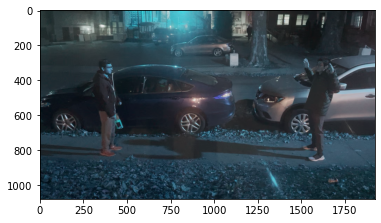

In [8]:
plt.imshow(twoPersonVideo[0])

#### Below shown is a template from the video and a template taken outside of the environment.

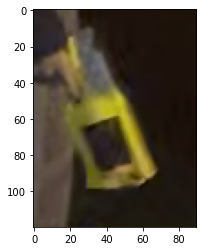

In [11]:
# Get Template
cleanVerticalTemplate = cv2.imread("data/clean_gun_vertical.png")
vidVerticalTemplate = cv2.imread("data/gun_vertical.png")
plt.imshow(vidVerticalTemplate)


#### Now, we must modify and compress the clean template from 4k to a more manageable 120x80 template like the dirty one for a safe comparison. Now, already observe how much different templates taken in different environments look, one is clearly lighter than the other.

(120, 90, 3)


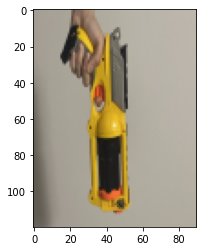

In [12]:
# make vertical template same size as the above template
cleanVerticalTemplate = cv2.resize(cleanVerticalTemplate, (vidVerticalTemplate.shape[1], vidVerticalTemplate.shape[0]), interpolation = cv2.INTER_AREA)
# apparently opencv reads in bgr, convert back to rgb for plt.imshow 
cleanVerticalTemplate= cv2.cvtColor(cleanVerticalTemplate, cv2.COLOR_BGR2RGB)
print(cleanVerticalTemplate.shape)
plt.imshow(cleanVerticalTemplate)


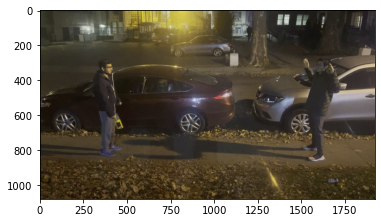

In [13]:
firstFrame = twoPersonVideo[0,:,:,:].copy()
firstFrame = cv2.cvtColor(firstFrame, cv2.COLOR_BGR2RGB) # convert to RGB for templatematching
plt.imshow(firstFrame)

In [23]:
# openCV method
print(firstFrame.shape)
print(vidVerticalTemplate.shape)
res = cv2.matchTemplate(firstFrame, vidVerticalTemplate, cv2.TM_CCORR_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
bestCoord = max_loc
allScores = res

(1080, 1920, 3)
(120, 90, 3)


Best Top Left Origin Coordinates: (410, 580)


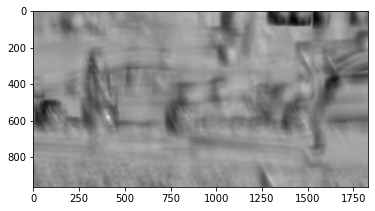

In [24]:
print("Best Top Left Origin Coordinates:", bestCoord)
plt.imshow(allScores, cmap='gray')

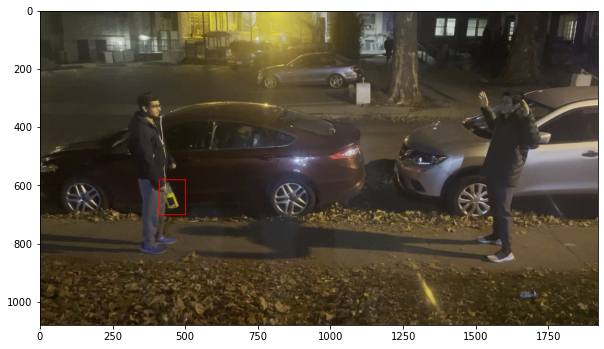

In [25]:
# convert to actual center point, note that openCV Best Coordinates
windowWidth = vidVerticalTemplate.shape[1]
windowHeight = vidVerticalTemplate.shape[0]
centeredRow = bestCoord[1] + windowHeight / 2
centeredCol = bestCoord[0] + windowWidth / 2
centeredBestCoords = (centeredRow , centeredCol)
bottomRight = (bestCoord[0] + windowWidth, bestCoord[1] + windowHeight)
boxedFirstFrame = firstFrame.copy()
cv2.rectangle(boxedFirstFrame, bestCoord, bottomRight, 255, 2)
plt.figure(figsize=(10,10))
plt.imshow(boxedFirstFrame)

#### So, in the above pictures, as expected, we can get the template perfectly if from the image directly. Gun Detection is possible with a very good template. Now, let's see how well template matching detection does when the template is not exactly the same orientation and same color as the video at hand.

In [17]:
res = cv2.matchTemplate(firstFrame, cleanVerticalTemplate, cv2.TM_CCORR_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
bestCoord = max_loc
allScores = res
print(bestCoord)

(29, 27)


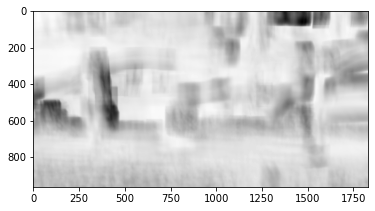

In [18]:
plt.imshow(allScores, cmap='gray')

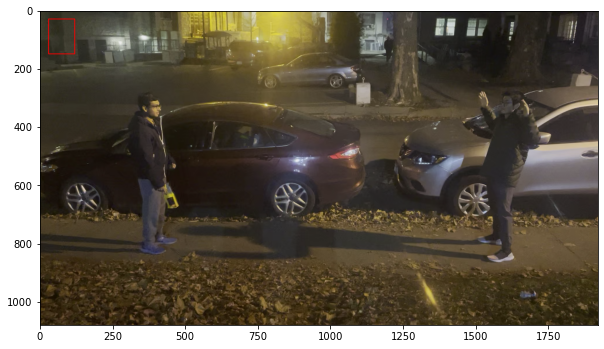

In [19]:
bottomRight = (bestCoord[0] + windowWidth, bestCoord[1] + windowHeight)
boxedFirstFrame = firstFrame.copy()
cv2.rectangle(boxedFirstFrame, bestCoord, bottomRight, 255, 2)
plt.figure(figsize=(10,10))
plt.imshow(boxedFirstFrame)

In [26]:
print("centered coordinates:", centeredBestCoords)

centered coordinates: (640.0, 455.0)


#### As shown above, the cleaned template fails miserably in normalized cross correlation template matching, thinking that the white background in the top left corner is the best match, which makes sense to a degree. First, the "cleaned" template has a white background with just a tint of yellow. The shape or orientation is not exactly the same. As such, for template matching to be robust, one must use a rotation invariant (whether through data augmentation or a difference distance metric) and a very well cut out template that matchse the object of interest directly.

#### This is using the in class implementation to do template matching with NCC, it is just substantially slower, but we show that we have used it and it can adequately produce the same results with the original template.

In [ ]:
allScores, bestCoord = ncc_scan(firstFrame,vidVerticalTemplate)


best match: (410, 580)


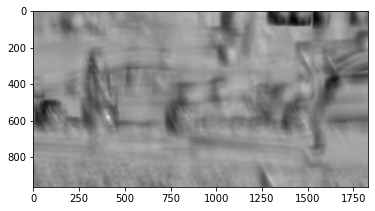

In [27]:
plt.imshow(allScores, cmap='gray')
print("best match:", bestCoord)

### Rieman Manifold Thresholding Quick Results To See If Plausible
#### In this section, we will get a good idea of how far apart our template actually is to the best location, specifically for the two person video.

In [29]:
# Define a bunch of important functions
def rieman_manifold(cModel, cCandidate):
    genEig, genEigVector = scipy.linalg.eig(cModel, cCandidate)
    genEig = np.log(genEig)
    genEig = np.square(genEig)
    sumCost = np.sum(genEig)
    sumCost = np.sqrt(sumCost)
    return sumCost

# note one key issue of python vs. matlab is again, we have to worry about starting row and column = 1
def compute_covariance(im, originRow, originCol, windowRows, windowCols):
    # 5 features.
    X = np.zeros((windowRows * windowCols,5))
    i = 0 # I'm too lazy to do row colum arithmetic 
    for row in range(originRow, originRow + windowRows): # rows are Y
        for col in range(originCol, originCol + windowCols): # columns are X
            X[i,0] = col + 1 # notice that we need to add 1 to match matlab values
            X[i,1] = row + 1  # y
            X[i,2] = im[row, col, 0] # R
            X[i,3] = im[row, col, 1] # G
            X[i,4] = im[row, col, 2]  # B
            i+=1
    cov = np.cov(np.transpose(X), bias=True) # add bias back in.
    return cov


### Quick Conclusions:

##### As expected, the distances of the template not sampled directly from the video has a much higher distance than the one from the video. As a quick conclusion, it doesn't make sense to threshold when the template match has failed in the first place in spite of being the same object. However, if the templates are exact, they are very much 0 or at least very close to 0, meaning that should one decide to choose a threshold, it should be an understandably small value, especially for RGB video with values ranging between 255. That being said, in our case, it would very hard to determine what a better threshold would be without more data. So we will just assume that the nerf gun has been detected for mean shift to see how well mean shift performs.

In [32]:
wcols, wrows = vidVerticalTemplate.shape[1], vidVerticalTemplate.shape[0]
cleanCov = compute_covariance(cleanVerticalTemplate,0,0, wrows, wcols)
dataCollectedCov = compute_covariance(vidVerticalTemplate,0,0,wrows,wcols)
actualCov = compute_covariance(firstFrame,580, 410,wrows,wcols)
print("Clean:", rieman_manifold(actualCov, cleanCov))
print("From Data:",rieman_manifold(actualCov, dataCollectedCov))

Clean: (3.5181384629179964+0j)
From Data: (2.1773112459703738e-14+0j)


#### Now, let's see how well meanshift can track once detection is performed. In this case, the best coordinates came from the direct template match, so those coordinates will be used.

### Mean shift Tracking - Continuously Track After The First Frame

In [ ]:
img1 = twoPersonVideo[0].copy()
radius = 10
img1CenterX = centeredBestCoords[1] # 
img1CenterY = centeredBestCoords[0] #
bins = 16
h = 10
nIter = 80
pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
print(pixelX.shape)
print(q_model.shape)

(305, 5)
(16, 16, 16)


In [ ]:
meanShiftedFrames = []
meanShiftedFrames.append(boxedFirstFrame)
for images in range(1,twoPersonVideo.shape[0]):
    img2 = twoPersonVideo[images].copy()
    y_best, dist = mean_shift_track(img2, q_model, radius, h, img1CenterX, img1CenterY, 80)
    print(images)
    # fig,ax = plt.subplots(1)
    # ax.set_aspect('equal')
    top_left = (int(y_best[0]) - 2* radius, int(y_best[1]) - 2*radius)
    btm_right = (int(y_best[0]) + 2*radius, int(y_best[1]) + 2*radius)
    print(top_left)
    cv2.rectangle(img2,top_left,btm_right, 255, 2)
    # Show the image
    # ax.imshow(img2)
    # circ = Circle((y_best[0],y_best[1]),radius, fill=False, color="red")
    # ax.add_patch(circ)
    # plt.savefig(f'images{images}.png')
    meanShiftedFrames.append(img2)
    #New Model and Center Points
    img1 = twoPersonVideo[images].copy()
    img1CenterX = y_best[0] # 
    img1CenterY = y_best[1] #
    pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
    q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
    
    

1
(437, 618)
2
(442, 616)
3
(446, 615)
4
(453, 612)
5
(458, 606)
6
(467, 599)
7
(475, 589)
8
(487, 581)
9
(500, 567)
10
(504, 563)
11
(515, 555)
12
(527, 543)
13
(537, 531)
14
(546, 515)
15
(555, 503)
16
(565, 488)
17
(571, 473)
18
(574, 458)
19
(579, 447)
20
(583, 434)
21
(586, 427)
22
(586, 417)
23
(589, 405)
24
(590, 394)
25
(594, 386)
26
(595, 379)
27
(595, 376)
28
(596, 372)
29
(592, 377)
30
(591, 381)
31
(589, 384)
32
(589, 384)
33
(588, 386)
34
(588, 383)
35
(588, 383)
36
(588, 386)
37
(587, 386)
38
(587, 386)
39
(586, 387)
40
(587, 390)
41
(587, 390)
42
(587, 387)
43
(589, 386)
44
(590, 387)
45
(590, 387)
46
(588, 392)
47
(590, 389)
48
(591, 390)
49
(593, 387)
50
(593, 387)
51
(592, 389)
52
(592, 391)
53
(592, 391)
54
(592, 391)
55
(593, 390)
56
(594, 390)
57
(595, 392)
58
(595, 393)
59
(595, 393)
60
(595, 400)
61
(597, 396)
62
(595, 395)
63
(595, 396)
64
(595, 398)
65
(596, 399)
66
(596, 399)
67
(594, 405)
68
(595, 408)
69
(594, 416)
70
(594, 416)
71
(595, 410)
72
(595, 411)
7

In [ ]:
meanShiftedFrames = np.array(meanShiftedFrames)


In [ ]:
imageio.mimsave('meanShifted.gif', meanShiftedFrames)

### If you look at the .gif file, you can see that it fails at the end. As such, let's pick three frames in time to show how it succeeds initially and then fails.

### Frame 10

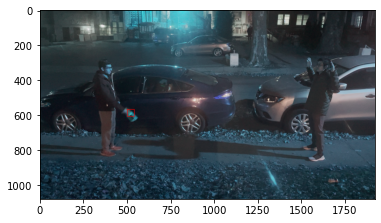

In [ ]:
plt.imshow(meanShiftedFrames[9])

### Frame 40

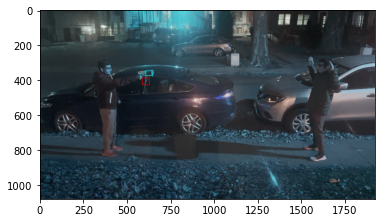

In [ ]:
plt.imshow(meanShiftedFrames[39])

### Frame 120

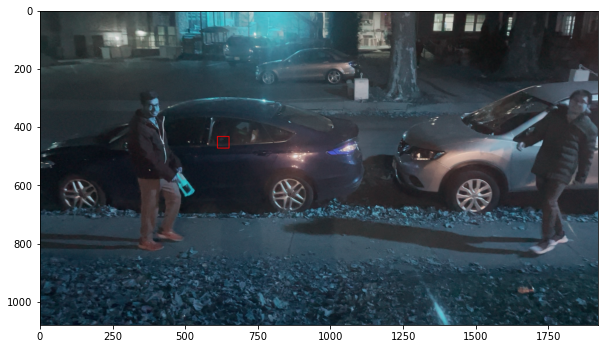

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(meanShiftedFrames[119])

#### Meanshift works great when tracking on a surface that is different than the object itself as shown in frames 0-40, but looking at the animationa s well as frame 120, it gets stuck on similar looking objects. In this case, it seems the reflections on the car combined with the black part looks close enough to the nerf gun that it fails to be tracked.

### Now, let's try to do it successfully for a controlled environment for the second walking video.

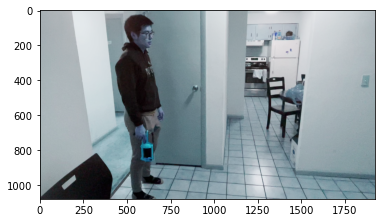

In [ ]:
plt.imshow(runningVideo[0])
walkFirstFrame = runningVideo[0].copy()

### Get Direct Template

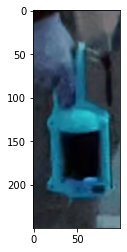

In [ ]:
perfectTemplate = runningVideo[0, 650:900, 560:660,:]
plt.imshow(perfectTemplate)

In [ ]:
res = cv2.matchTemplate(walkFirstFrame, perfectTemplate, cv2.TM_CCORR_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
bestCoord = max_loc
allScores = res

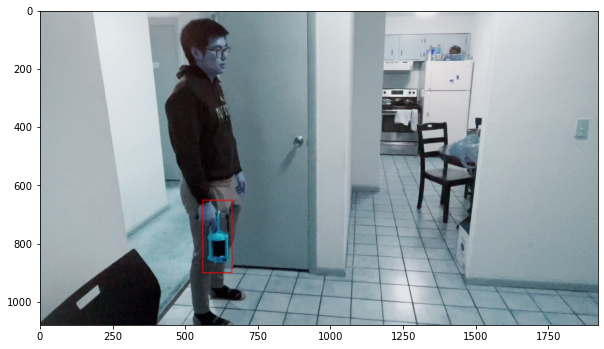

In [ ]:
# convert to actual center point, note that openCV Best Coordinates
windowWidth = perfectTemplate.shape[1]
windowHeight = perfectTemplate.shape[0]
centeredRow = bestCoord[1] + windowHeight / 2
centeredCol = bestCoord[0] + windowWidth / 2
centeredBestCoords = (centeredRow , centeredCol)
bottomRight = (bestCoord[0] + windowWidth, bestCoord[1] + windowHeight)
boxedFirstFrame = walkFirstFrame.copy()
cv2.rectangle(boxedFirstFrame, bestCoord, bottomRight, 255, 2)
plt.figure(figsize=(10,10))
plt.imshow(boxedFirstFrame)

In [ ]:
print(centeredBestCoords)

(775.0, 610.0)


### Meanshift 

In [ ]:
img1 = runningVideo[0].copy()
radius = 10
img1CenterX = centeredBestCoords[1] # 
img1CenterY = centeredBestCoords[0] #
bins = 16
h = 10
nIter = 80
pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
print(pixelX.shape)
print(q_model.shape)

(305, 5)
(16, 16, 16)


In [ ]:
walkingMeanShiftedFrames = []
walkingMeanShiftedFrames.append(boxedFirstFrame)
for images in range(1,twoPersonVideo.shape[0]):
    img2 = runningVideo[images].copy()
    y_best, dist = mean_shift_track(img2, q_model, radius, h, img1CenterX, img1CenterY, 80)
    print(images)
    # fig,ax = plt.subplots(1)
    # ax.set_aspect('equal')
    top_left = (int(y_best[0]) - 2* radius, int(y_best[1]) - 2*radius)
    btm_right = (int(y_best[0]) + 2*radius, int(y_best[1]) + 2*radius)
    print(top_left)
    cv2.rectangle(img2,top_left,btm_right, 255, 2)
    # Show the image
    # ax.imshow(img2)
    # circ = Circle((y_best[0],y_best[1]),radius, fill=False, color="red")
    # ax.add_patch(circ)
    # plt.savefig(f'images{images}.png')
    walkingMeanShiftedFrames.append(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    #New Model and Center Points
    img1 = runningVideo[images].copy()
    img1CenterX = y_best[0] # 
    img1CenterY = y_best[1] #
    pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
    q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
    
    

1
(590, 755)
2
(592, 759)
3
(595, 763)
4
(599, 765)
5
(602, 767)
6
(606, 768)
7
(609, 770)
8
(613, 773)
9
(615, 775)
10
(616, 777)
11
(619, 781)
12
(624, 783)
13
(630, 785)
14
(637, 786)
15
(645, 788)
16
(655, 788)
17
(660, 783)
18
(667, 778)
19
(674, 766)
20
(687, 764)
21
(695, 756)
22
(702, 743)
23
(716, 739)
24
(725, 737)
25
(736, 740)
26
(740, 739)
27
(741, 739)
28
(746, 737)
29
(751, 742)
30
(756, 745)
31
(759, 753)
32
(765, 759)
33
(768, 769)
34
(772, 776)
35
(775, 780)
36
(779, 783)
37
(782, 783)
38
(786, 784)
39
(796, 787)
40
(810, 790)
41
(818, 798)
42
(830, 797)
43
(848, 795)
44
(864, 793)
45
(877, 789)
46
(901, 788)
47
(919, 786)
48
(936, 777)
49
(954, 775)
50
(977, 770)
51
(990, 763)
52
(1005, 758)
53
(1018, 745)
54
(1034, 730)
55
(1044, 719)
56
(1052, 709)
57
(1056, 706)
58
(1065, 703)
59
(1073, 701)
60
(1085, 702)
61
(1089, 704)
62
(1093, 706)
63
(1095, 702)
64
(1092, 709)
65
(1097, 717)
66
(1100, 725)
67
(1099, 733)
68
(1106, 745)
69
(1115, 751)
70
(1125, 749)
71
(1136, 

In [ ]:
imageio.mimsave('meanShiftedWalking.gif', walkingMeanShiftedFrames)

### Frame 10

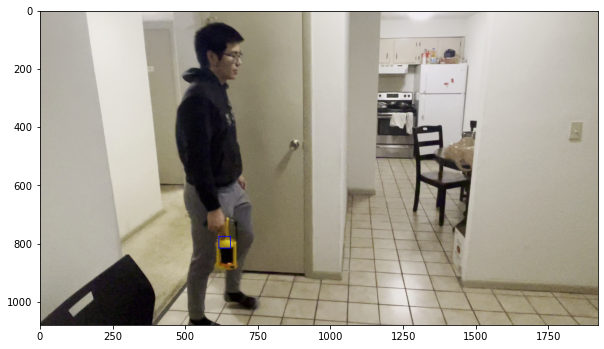

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(walkingMeanShiftedFrames[9])

### Frame 30

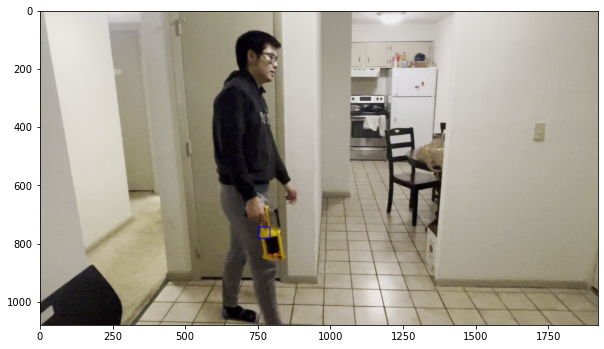

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(walkingMeanShiftedFrames[29])

### Frame 50

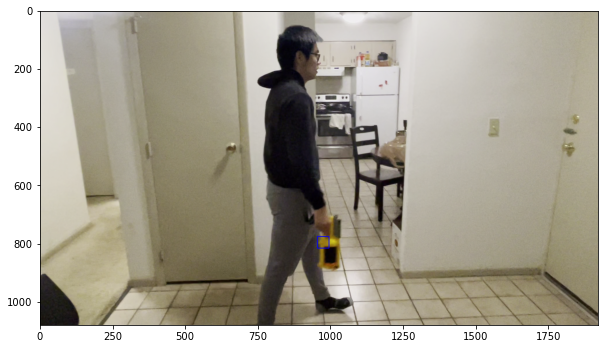

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(walkingMeanShiftedFrames[49])

### Although a little hard to see, we can see the block box staying on the entire yellow nerf gun across all of the frames.

In [ ]:
### Output all the stuff to a video.

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('twoPersonSubmission.mp4', fourcc, 20.0, (1920,1080))
for i in range(len(walkingMeanShiftedFrames)):
    frame = walkingMeanShiftedFrames[i]
    out.write(frame)

out.release()

out = cv2.VideoWriter('walkingSubmission.mp4', fourcc, 20.0, (1920,1080))
for i in range(meanShiftedFrames.shape[0]):
    frame = meanShiftedFrames[i]
    out.write(frame)

out.release()